<a href="https://colab.research.google.com/github/pedrov718/classifying_mental_health_with_NN/blob/main/nueral_network_classifyer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.utils import np_utils
from sklearn import preprocessing

In [2]:
posts = pd.read_excel("/content/mental_health_posts_scraped.xlsx", index_col= 'Unnamed: 0')

In [3]:
posts.rename(columns = {"Origin":'label'}, inplace = True)

In [4]:
labels = pd.get_dummies(posts.label, drop_first= False)

In [5]:
posts = posts.join(labels)

In [6]:
posts.sample(1)

,Title,Post Text,ID,Score,Total Comments,label,Post URL,text,Anxiety,BPD,autism,bipolar,depression,schizophrenia
18415,PLEASE BE HONEST,"Okay r/schizophrenia, I have an English projec...",5sgzs0,0,2,schizophrenia,https://www.reddit.com/r/schizophrenia/comment...,"PLEASE BE HONESTOkay r/schizophrenia, I have a...",0,0,0,0,0,1


In [7]:
posts.columns[7:].values

array(['text', 'Anxiety', 'BPD', 'autism', 'bipolar', 'depression',
       'schizophrenia'], dtype=object)

In [8]:
df = posts[posts.columns[7:].values]

In [9]:
df[posts.columns[8:].values].sum()

Anxiety          3119
BPD              3260
autism           3444
bipolar          3272
depression       3301
schizophrenia    3291
dtype: int64

In [10]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=512):
  df = dataframe.copy()
  labels = df[posts.columns[8:].values]
  df = df["text"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [12]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

## Embedding our corpus with a pretrained TF HUB model

In [35]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [36]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(512, 50), dtype=float32, numpy=
array([[ 1.4431262 , -0.17821333, -0.59724873, ..., -0.79739237,
         0.0896387 , -0.20190561],
       [ 0.51712453,  0.16922396, -0.18801749, ..., -0.3510356 ,
        -0.2852852 , -0.03374095],
       [ 0.07202606,  0.01054991, -0.11568081, ..., -0.096197  ,
        -0.0604799 , -0.01286972],
       ...,
       [ 0.51088035, -0.08258942, -0.0661604 , ..., -0.3191115 ,
         0.10510099, -0.15100189],
       [ 0.41241935, -0.07515784, -0.12606712, ..., -0.25928864,
        -0.10066891,  0.07335939],
       [ 2.0929747 ,  0.60047317,  0.7549739 , ..., -0.04339394,
         1.0225626 ,  1.0369064 ]], dtype=float32)>

## Creating our word embedded Model

In [37]:
seq_model = tf.keras.Sequential()
seq_model.add(hub_layer)
seq_model.add(tf.keras.layers.Dense(64, activation='relu'))
seq_model.add(tf.keras.layers.Dropout(0.4))
seq_model.add(tf.keras.layers.Dense(32, activation='relu'))
seq_model.add(tf.keras.layers.Dropout(0.4))
seq_model.add(tf.keras.layers.Dense(16, activation='relu'))
seq_model.add(tf.keras.layers.Dropout(0.4))
seq_model.add(tf.keras.layers.Dense(6, activation='sigmoid'))

In [38]:
seq_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(), #loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [39]:
seq_model.evaluate(train_data)

31/31 [==============================] - 1s 21ms/step - loss: 1.8238 - accuracy: 0.1639


[1.8238054513931274, 0.16388341784477234]

In [40]:
seq_model.evaluate(valid_data)

4/4 [==============================] - 0s 23ms/step - loss: 1.8324 - accuracy: 0.1519


[1.8323692083358765, 0.1518537402153015]

In [41]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights= True)

In [42]:
history = seq_model.fit(train_data, epochs=1000, validation_data=valid_data, callbacks=[callback])

Epoch 1/1000
31/31 [==============================] - 20s 603ms/step - loss: 1.8047 - accuracy: 0.1871 - val_loss: 1.7760 - val_accuracy: 0.2280
Epoch 2/1000
31/31 [==============================] - 18s 562ms/step - loss: 1.7763 - accuracy: 0.2112 - val_loss: 1.7587 - val_accuracy: 0.2616
Epoch 3/1000
31/31 [==============================] - 18s 553ms/step - loss: 1.7562 - accuracy: 0.2386 - val_loss: 1.7286 - val_accuracy: 0.2829
Epoch 4/1000
31/31 [==============================] - 18s 576ms/step - loss: 1.7234 - accuracy: 0.2609 - val_loss: 1.6741 - val_accuracy: 0.3195
Epoch 5/1000
31/31 [==============================] - 17s 559ms/step - loss: 1.6638 - accuracy: 0.2867 - val_loss: 1.5864 - val_accuracy: 0.3687
Epoch 6/1000
31/31 [==============================] - 17s 561ms/step - loss: 1.5759 - accuracy: 0.3321 - val_loss: 1.4847 - val_accuracy: 0.4043
Epoch 7/1000
31/31 [==============================] - 18s 598ms/step - loss: 1.4635 - accuracy: 0.3843 - val_loss: 1.3914 - val_ac

In [43]:
seq_model.evaluate(test_data)

4/4 [==============================] - 0s 62ms/step - loss: 9.2475 - accuracy: 0.6293


[9.24746322631836, 0.6292534470558167]

In [50]:
# loading library
import pickle
# create an iterator object with write permission - model.pkl
with open('sequential_classifyer', 'wb') as files:
    pickle.dump(seq_model, files)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


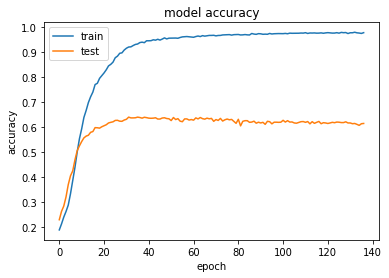

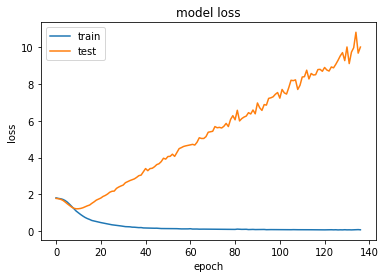

In [44]:
# list all data in history
print(history.history.keys())


# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Bidirectional LSTM

In [37]:
train_data = df_to_dataset(train, batch_size= 512)
valid_data = df_to_dataset(val, batch_size= 512)
test_data = df_to_dataset(test, batch_size= 512)

In [38]:
encoder = tf.keras.layers.TextVectorization(ngrams= 2, max_tokens=2000)

encoder.adapt(list(train_data)[0][0])

In [39]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]
len(encoder.get_vocabulary())

2000

In [40]:
bi_lstm = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

In [41]:
bi_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [42]:
bi_lstm.evaluate(train_data)

bi_lstm.evaluate(valid_data)

4/4 [==============================] - 32s 8s/step - loss: 1.7916 - accuracy: 0.1798


[1.7915542125701904, 0.17978669703006744]

In [43]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights= True)

In [ ]:
history2 = bi_lstm.fit(train_data, epochs=50, validation_data=valid_data, callbacks=[callback])

Epoch 1/50
 9/31 [=======>......................] - ETA: 7:59 - loss: 1.7811 - accuracy: 0.1886

In [ ]:
bi_lstm.evaluate(test_data)

In [ ]:
# list all data in history
print(history2.history.keys())


# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
# loading library
import pickle
# create an iterator object with write permission - model.pkl
with open('bidirectional_classifyer', 'wb') as files:
    pickle.dump(bi_lstm, files)

In [ ]:
from google.colab import files
files.download('bidirectional_classifyer.pkl')

## Using LIT API to visualize our model

In [ ]:
import sys

from absl import app
from absl import flags
from absl import logging

from lit_nlp import dev_server
from lit_nlp import server_flags
from lit_nlp.api import model as lit_model
from lit_nlp.api import types as lit_types
# Use the regular GLUE data loaders, because these are very simple already.
from lit_nlp.examples.datasets import glue
from lit_nlp.lib import utils

import tensorflow as tf
import transformers

# NOTE: additional flags defined in server_flags.py

FLAGS = flags.FLAGS

FLAGS.set_default("development_demo", True)

flags.DEFINE_string(
    "model_path",
    "https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz",
    "Path to trained model, in standard transformers format, e.g. as "
    "saved by model.save_pretrained() and tokenizer.save_pretrained()")


def _from_pretrained(cls, *args, **kw):
  """Load a transformers model in TF2, with fallback to PyTorch weights."""
  try:
    return cls.from_pretrained(*args, **kw)
  except OSError as e:
    logging.warning("Caught OSError loading model: %s", e)
    logging.warning(
        "Re-trying to convert from PyTorch checkpoint (from_pt=True)")
    return cls.from_pretrained(*args, from_pt=True, **kw)


class SimpleSentimentModel(lit_model.Model):
  """Simple sentiment analysis model."""

  #LABELS = ["0", "1"]  # negative, positive
  LABELS = ['Anxiety', 'BPD', 'autism', 'bipolar', 'depression',
       'schizophrenia']

  def __init__(self, model_name_or_path):
    self.tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_name_or_path)
    model_config = transformers.AutoConfig.from_pretrained(
        model_name_or_path,
        num_labels=2,
        output_hidden_states=True,
        output_attentions=True,
    )
    # This is a just a regular Keras model.
    self.model = _from_pretrained(
        transformers.TFAutoModelForSequenceClassification,
        model_name_or_path,
        config=model_config)

  ##
  # LIT API implementation
  def max_minibatch_size(self):
    # This tells lit_model.Model.predict() how to batch inputs to
    # predict_minibatch().
    # Alternately, you can just override predict() and handle batching yourself.
    return 32

  def predict_minibatch(self, inputs):
    # Preprocess to ids and masks, and make the input batch.
    encoded_input = self.tokenizer.batch_encode_plus(
        [ex["sentence"] for ex in inputs],
        return_tensors="tf",
        add_special_tokens=True,
        max_length=128,
        padding="longest",
        truncation="longest_first")

    # Run a forward pass.
    out: transformers.modeling_tf_outputs.TFSequenceClassifierOutput = \
        self.model(encoded_input, training=False)

    # Post-process outputs.
    batched_outputs = {
        "probas": tf.nn.softmax(out.logits, axis=-1),
        "input_ids": encoded_input["input_ids"],
        "ntok": tf.reduce_sum(encoded_input["attention_mask"], axis=1),
        "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
    }
    # Return as NumPy for further processing.
    detached_outputs = {k: v.numpy() for k, v in batched_outputs.items()}
    # Unbatch outputs so we get one record per input example.
    for output in utils.unbatch_preds(detached_outputs):
      ntok = output.pop("ntok")
      output["tokens"] = self.tokenizer.convert_ids_to_tokens(
          output.pop("input_ids")[1:ntok - 1])
      yield output

  def input_spec(self) -> lit_types.Spec:
    return {
        "sentence": lit_types.TextSegment(),
        "label": lit_types.CategoryLabel(vocab=self.LABELS, required=False)
    }

  def output_spec(self) -> lit_types.Spec:
    return {
        "tokens": lit_types.Tokens(),
        "probas": lit_types.MulticlassPreds(parent="label", vocab=self.LABELS,
                                            null_idx=0),
        "cls_emb": lit_types.Embeddings()
    }


def get_wsgi_app():
  """Returns a LitApp instance for consumption by gunicorn."""
  FLAGS.set_default("server_type", "external")
  FLAGS.set_default("demo_mode", True)
  # Parse flags without calling app.run(main), to avoid conflict with
  # gunicorn command line flags.
  unused = flags.FLAGS(sys.argv, known_only=True)
  return main(unused)


def main(_):
  # Normally path is a directory; if it's an archive file, download and
  # extract to the transformers cache.
  model_path = FLAGS.model_path
  if model_path.endswith(".tar.gz"):
    model_path = transformers.file_utils.cached_path(
        model_path, extract_compressed_file=True)

  # Load the model we defined above.
  models = {"sst": SimpleSentimentModel(model_path)}
  # Load SST-2 validation set from TFDS.
  datasets = {"sst_dev": glue.SST2Data("validation")}

  # Start the LIT server. See server_flags.py for server options.
  lit_demo = dev_server.Server(models, datasets, **server_flags.get_flags())
  return lit_demo.serve()


if __name__ == "__main__":
  app.run(main)